In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load data
df = pd.read_csv("../data/clean_data/sleep_depression_final_dataset.csv")

# Example: assuming you have columns like these
feature_columns = [
    'fit_ss_sleepperiod_minutes', 'fit_ss_light_minutes',
    'fit_ss_deep_minutes', 'fit_ss_rem_minutes', 'sleep_efficiency'
]
sequence_length = 14  # number of time steps (e.g., 2 weeks)
target_column = 'depression_present'  # or whatever your binary label is

# Sort by subject and time (adjust this to your data’s structure)
df = df.sort_values(by=["src_subject_id", "fit_ss_sleepdate"])

# Group and reshape
sequences = []
labels = []
for subject, group in df.groupby('src_subject_id'):
    if len(group) >= sequence_length:
        group = group.head(sequence_length)
        features = group[feature_columns].to_numpy()
        label = group[target_column].iloc[0]  # or mode/mean if needed
        sequences.append(features)
        labels.append(label)

X = np.array(sequences)
y = np.array(labels)

print("X shape:", X.shape)  # (samples, time steps, features)
print("y shape:", y.shape)  # (samples,)


X shape: (837, 14, 5)
y shape: (837,)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


# Build LSTM model
def build_lstm_model(input_shape, lstm_units=64, dropout_rate=0.3, learning_rate=0.001):
    model = Sequential([
        Masking(mask_value=0.0, input_shape=input_shape),
        LSTM(lstm_units),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Train LSTM with given parameters
def train_lstm_model(X_train, y_train, X_val, y_val, params, verbose=1):
    model = build_lstm_model(
        input_shape=(X_train.shape[1], X_train.shape[2]),
        lstm_units=params.get('lstm_units', 64),
        dropout_rate=params.get('dropout_rate', 0.3),
        learning_rate=params.get('learning_rate', 0.001)
    )

    history = model.fit(
        X_train, y_train,
        epochs=params.get('epochs', 20),
        batch_size=params.get('batch_size', 32),
        validation_data=(X_val, y_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
        verbose=verbose
    )

    return model, history


# Evaluate model performance
def evaluate_lstm_model(model, X_test, y_test):
    y_pred_proba = model.predict(X_test).flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)

    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", round(roc_auc_score(y_test, y_pred_proba), 3))

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_pred_proba):.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [19]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")


Train: (585, 14, 5), Validation: (126, 14, 5), Test: (126, 14, 5)


Epoch 1/20


/opt/homebrew/Caskroom/miniforge/base/envs/diss/lib/python3.11/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.3580 - loss: 0.9249 - val_accuracy: 0.7460 - val_loss: 0.5859
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7053 - loss: 0.6023 - val_accuracy: 0.7460 - val_loss: 0.5667
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7335 - loss: 0.6032 - val_accuracy: 0.7460 - val_loss: 0.5626
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7476 - loss: 0.5745 - val_accuracy: 0.7460 - val_loss: 0.5620
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7510 - loss: 0.5747 - val_accuracy: 0.7460 - val_loss: 0.5615
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7312 - loss: 0.6106 - val_accuracy: 0.7460 - val_loss: 0.5617
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7447 - loss: 0.5749 - val_accuracy: 0.7460 - val_loss: 0.5593
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7412 - loss: 0.5722 - val_accuracy: 0.7460 - val_loss: 0.5601
Ep

/opt/homebrew/Caskroom/miniforge/base/envs/diss/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/diss/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/diss/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

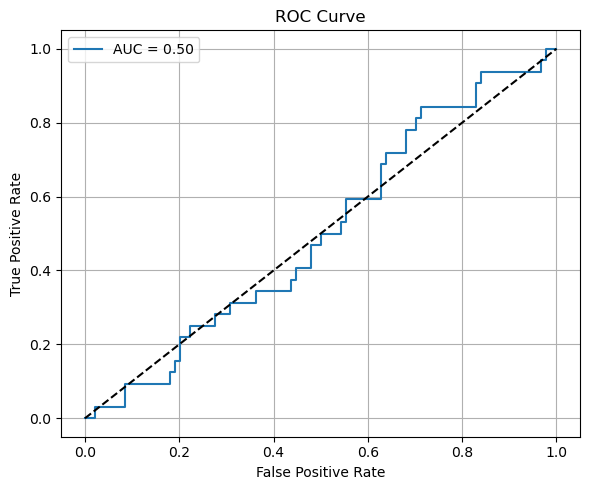

In [20]:
params = {
    'lstm_units': 64,
    'dropout_rate': 0.3,
    'learning_rate': 0.001,
    'epochs': 20,
    'batch_size': 32
}

model, history = train_lstm_model(X_train, y_train, X_val, y_val, params)
evaluate_lstm_model(model, X_test, y_test)

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4717 - loss: 0.7009 - val_accuracy: 0.4048 - val_loss: 0.6941
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5072 - loss: 0.6882 - val_accuracy: 0.3651 - val_loss: 0.6974
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4887 - loss: 0.6854 - val_accuracy: 0.5000 - val_loss: 0.6937
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4808 - loss: 0.7009 - val_accuracy: 0.6349 - val_loss: 0.6858
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4803 - loss: 0.7325 - val_accuracy: 0.6508 - val_loss: 0.6864
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5294 - loss: 0.7063 - val_accuracy: 0.5159 - val_loss: 0.7005
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4744 - loss: 0.7048 - val_accuracy: 0.3730 - val_loss: 0.7067
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4654 - loss: 0.7146 - val_accuracy: 0.3016 - val_lo

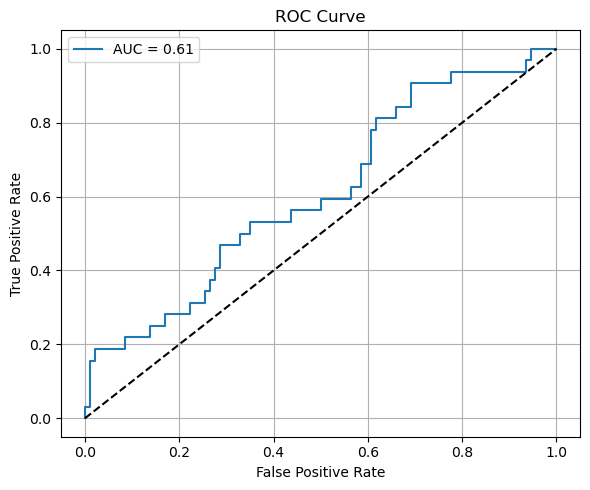

In [22]:
from sklearn.utils import class_weight

# Compute class weights
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(weights))

# In model.fit
model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=params['epochs'],
          batch_size=params['batch_size'],
          class_weight=class_weights,
          verbose=1)
evaluate_lstm_model(model, X_test, y_test)
